In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.mstl_utils import performMSTL, plotMSTLResults, process_city_stl


C:\Users\grube\AppData\Local\Temp\ipykernel_3380\3244569106.py:6: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv("../data/cleaned_full_data.csv")


## Method to apply iterative decomposition on each counter of each city

In [ ]:
d = pd.read_csv("../data/cleaned_full_data.csv")
for city, df_city in d.groupby("city"):
    print("Processing city: ", city)
    process_city_stl(df_city, city)
    print("Finished city", city)


## Example results for Freiburg

In [2]:
process_city_stl(d, "Stadt Freiburg")

Processed counter 100004595 in city 'Stadt Freiburg'
Processed counter 100014511 in city 'Stadt Freiburg'
Processed counter 100014585 in city 'Stadt Freiburg'


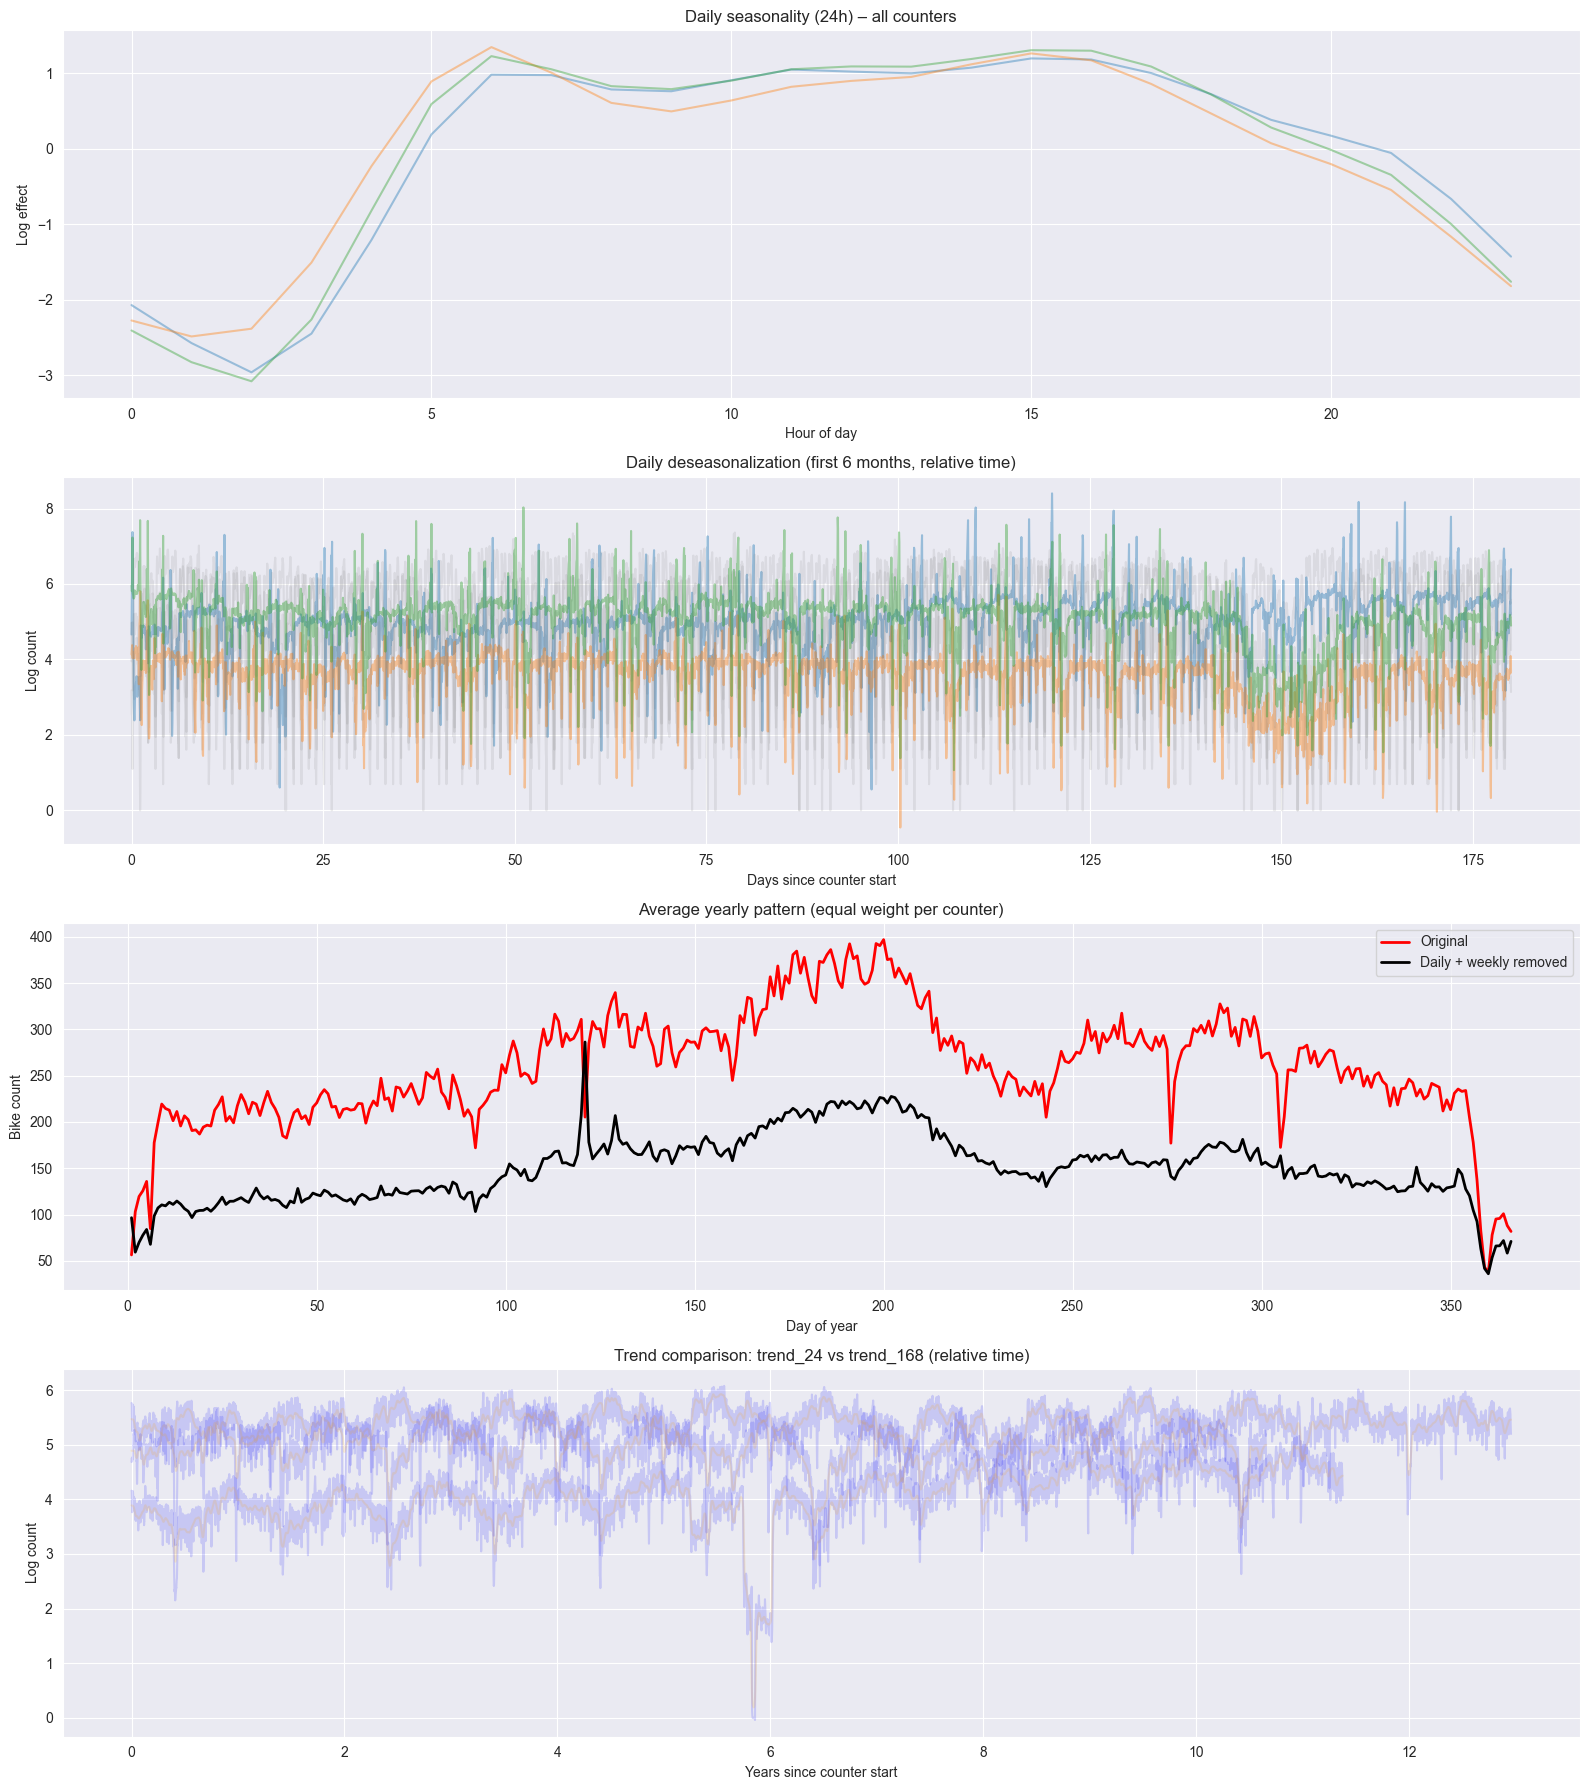

In [52]:
df = pd.read_csv("../data/stl_results.csv", parse_dates=["timestamp"])
df = df.set_index("timestamp")

df = pd.read_csv("../data/stl_results.csv", parse_dates=["timestamp"])
df = df.set_index("timestamp")

df = df.copy()
df["year"] = df.index.year
df["dayofyear"] = df.index.dayofyear
df["hour"] = df.index.hour

df["count_deseasonalized_week"] = np.expm1(df["log_count_deseasonalized_week"])
df["count_orig"] = np.expm1(df["log_count"])

fig, axes = plt.subplots(4, 1, figsize=(16, 18))

# ==================================================
# 1) Daily seasonality (aligned by hour-of-day)
# ==================================================
for cid, g in df.groupby("counter_site_id"):
    daily_profile = g.groupby("hour")["seasonal_24"].mean()
    axes[0].plot(daily_profile.index, daily_profile.values, alpha=0.4)

axes[0].set_title("Daily seasonality (24h) – all counters")
axes[0].set_xlabel("Hour of day")
axes[0].set_ylabel("Log effect")

# ==================================================
# 2) Original vs daily-deseasonalized
#    (first calendar year per counter)
# ==================================================
for cid, g in df.groupby("counter_site_id"):
    g = g.sort_index().iloc[:24 * 180]  # first 6 months
    t = np.arange(len(g)) / 24          # days since start

    axes[1].plot(t, g["log_count"], color="gray", alpha=0.15)
    axes[1].plot(t, g["log_count_deseasonalized"], alpha=0.4)

axes[1].set_title("Daily deseasonalization (first 6 months, relative time)")
axes[1].set_xlabel("Days since counter start")
axes[1].set_ylabel("Log count")


# ==================================================
# 3) Yearly pattern (balanced across counters)
# ==================================================
yearly_orig = (
    df.groupby(["counter_site_id", "dayofyear"])["count_orig"]
      .mean()
      .groupby("dayofyear")
      .mean()
)

yearly_ds = (
    df.groupby(["counter_site_id", "dayofyear"])["count_deseasonalized_week"]
      .mean()
      .groupby("dayofyear")
      .mean()
)

axes[2].plot(yearly_orig.index, yearly_orig.values,
             color="red", linewidth=2, label="Original")
axes[2].plot(yearly_ds.index, yearly_ds.values,
             color="black", linewidth=2, label="Daily + weekly removed")

axes[2].set_title("Average yearly pattern (equal weight per counter)")
axes[2].set_xlabel("Day of year")
axes[2].set_ylabel("Bike count")
axes[2].legend()

# ==================================================
# 4) Trend comparison (relative time per counter)
# ==================================================
for cid, g in df.groupby("counter_site_id"):
    t = np.arange(len(g)) / 24 / 365  # years since counter start
    axes[3].plot(t, g["trend_24"], color="blue", alpha=0.15)
    axes[3].plot(t, g["trend_168"], color="orange", alpha=0.15)

axes[3].set_title("Trend comparison: trend_24 vs trend_168 (relative time)")
axes[3].set_xlabel("Years since counter start")
axes[3].set_ylabel("Log count")

plt.tight_layout()
plt.show()
